# Bone Metastasis Classification - Using 10 Images (5 Normal 5 Abnormal)

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

### Load Data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

batch_size = 4

trainset = datasets.ImageFolder(root=r"dataset\train", transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.ImageFolder(root=r"dataset\test", transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = (0, 1)

    0     0     0     1


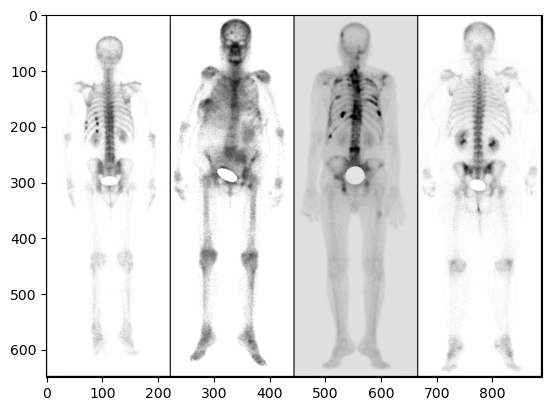

In [3]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
plt.imshow(torchvision.utils.make_grid(images).squeeze().permute(1,2,0))
# print labels
print(' '.join(f'{classes[labels[j]]:5}' for j in range(batch_size)))

In [4]:
# DEPRECATED
class CustomDataset(Dataset):
    def __init__(self, labels_filepath, img_dir):
        self.img_dir = img_dir
        self.img_labels = labels_filepath
        self.transform = ToTensor()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # Read image as greyscale
        image = Image.open(img_path)#.convert("L")
        # Convert PIL Image to tensor, scale values to range [0, 1]
        image = self.transform(image)
        label = self.img_labels.iloc[idx, 1]
        return image, label

### Define Model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, 5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3 * 158 * 52, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(F.relu(self.conv(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [10]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train Model

In [11]:
epochs = 10

In [12]:
losses = []

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i>0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i:.3f}')
            losses.append(running_loss / i)

print('Finished Training')

[1,     2] loss: 4.616
[1,     3] loss: 3.453
[1,     4] loss: 3.069
[1,     5] loss: 2.875
[1,     6] loss: 2.757
[1,     7] loss: 2.678
[1,     8] loss: 2.620
[1,     9] loss: 2.576
[1,    10] loss: 2.541
[1,    11] loss: 2.512
[1,    12] loss: 2.488
[1,    13] loss: 2.466
[1,    14] loss: 2.444
[1,    15] loss: 2.424
[1,    16] loss: 2.405
[1,    17] loss: 2.385
[1,    18] loss: 2.352
[1,    19] loss: 2.316
[1,    20] loss: 2.251
[1,    21] loss: 2.185
[1,    22] loss: 2.176
[1,    23] loss: 2.124
[1,    24] loss: 2.070
[1,    25] loss: 2.031
[1,    26] loss: 1.979
[1,    27] loss: 1.925
[1,    28] loss: 1.881
[1,    29] loss: 1.868
[1,    30] loss: 1.845
[1,    31] loss: 1.823
[1,    32] loss: 1.792
[1,    33] loss: 1.764
[1,    34] loss: 1.741
[1,    35] loss: 1.720
[1,    36] loss: 1.691
[1,    37] loss: 1.687
[1,    38] loss: 1.682
[1,    39] loss: 1.646
[1,    40] loss: 1.621
[1,    41] loss: 1.601
[1,    42] loss: 1.581
[1,    43] loss: 1.559
[1,    44] loss: 1.539
[1,    45] 

[2,   153] loss: 0.699
[2,   154] loss: 0.698
[2,   155] loss: 0.697
[2,   156] loss: 0.695
[2,   157] loss: 0.692
[2,   158] loss: 0.694
[2,   159] loss: 0.693
[2,   160] loss: 0.690
[2,   161] loss: 0.686
[2,   162] loss: 0.690
[2,   163] loss: 0.694
[2,   164] loss: 0.697
[2,   165] loss: 0.701
[2,   166] loss: 0.701
[2,   167] loss: 0.699
[2,   168] loss: 0.700
[2,   169] loss: 0.703
[2,   170] loss: 0.704
[2,   171] loss: 0.705
[2,   172] loss: 0.706
[2,   173] loss: 0.707
[2,   174] loss: 0.707
[2,   175] loss: 0.707
[2,   176] loss: 0.707
[2,   177] loss: 0.707
[2,   178] loss: 0.706
[2,   179] loss: 0.705
[2,   180] loss: 0.705
[2,   181] loss: 0.704
[2,   182] loss: 0.705
[2,   183] loss: 0.704
[2,   184] loss: 0.702
[2,   185] loss: 0.706
[2,   186] loss: 0.707
[2,   187] loss: 0.706
[2,   188] loss: 0.706
[2,   189] loss: 0.706
[2,   190] loss: 0.706
[2,   191] loss: 0.707
[2,   192] loss: 0.706
[2,   193] loss: 0.707
[2,   194] loss: 0.707
[2,   195] loss: 0.707
[2,   196] 

[4,    95] loss: 0.702
[4,    96] loss: 0.698
[4,    97] loss: 0.697
[4,    98] loss: 0.699
[4,    99] loss: 0.700
[4,   100] loss: 0.699
[4,   101] loss: 0.700
[4,   102] loss: 0.699
[4,   103] loss: 0.699
[4,   104] loss: 0.700
[4,   105] loss: 0.700
[4,   106] loss: 0.701
[4,   107] loss: 0.701
[4,   108] loss: 0.700
[4,   109] loss: 0.700
[4,   110] loss: 0.701
[4,   111] loss: 0.700
[4,   112] loss: 0.697
[4,   113] loss: 0.698
[4,   114] loss: 0.699
[4,   115] loss: 0.700
[4,   116] loss: 0.701
[4,   117] loss: 0.697
[4,   118] loss: 0.703
[4,   119] loss: 0.704
[4,   120] loss: 0.703
[4,   121] loss: 0.701
[4,   122] loss: 0.698
[4,   123] loss: 0.699
[4,   124] loss: 0.696
[4,   125] loss: 0.695
[4,   126] loss: 0.696
[4,   127] loss: 0.695
[4,   128] loss: 0.696
[4,   129] loss: 0.695
[4,   130] loss: 0.692
[4,   131] loss: 0.691
[4,   132] loss: 0.688
[4,   133] loss: 0.692
[4,   134] loss: 0.693
[4,   135] loss: 0.694
[4,   136] loss: 0.693
[4,   137] loss: 0.694
[4,   138] 

[6,    37] loss: 0.676
[6,    38] loss: 0.686
[6,    39] loss: 0.688
[6,    40] loss: 0.689
[6,    41] loss: 0.690
[6,    42] loss: 0.689
[6,    43] loss: 0.689
[6,    44] loss: 0.689
[6,    45] loss: 0.690
[6,    46] loss: 0.690
[6,    47] loss: 0.691
[6,    48] loss: 0.691
[6,    49] loss: 0.692
[6,    50] loss: 0.694
[6,    51] loss: 0.693
[6,    52] loss: 0.692
[6,    53] loss: 0.692
[6,    54] loss: 0.690
[6,    55] loss: 0.689
[6,    56] loss: 0.690
[6,    57] loss: 0.688
[6,    58] loss: 0.684
[6,    59] loss: 0.685
[6,    60] loss: 0.683
[6,    61] loss: 0.685
[6,    62] loss: 0.683
[6,    63] loss: 0.676
[6,    64] loss: 0.675
[6,    65] loss: 0.673
[6,    66] loss: 0.677
[6,    67] loss: 0.676
[6,    68] loss: 0.680
[6,    69] loss: 0.683
[6,    70] loss: 0.681
[6,    71] loss: 0.679
[6,    72] loss: 0.678
[6,    73] loss: 0.676
[6,    74] loss: 0.677
[6,    75] loss: 0.679
[6,    76] loss: 0.680
[6,    77] loss: 0.678
[6,    78] loss: 0.679
[6,    79] loss: 0.680
[6,    80] 

[7,   188] loss: 0.700
[7,   189] loss: 0.701
[7,   190] loss: 0.700
[7,   191] loss: 0.699
[7,   192] loss: 0.699
[7,   193] loss: 0.698
[7,   194] loss: 0.698
[7,   195] loss: 0.697
[7,   196] loss: 0.698
[7,   197] loss: 0.697
[7,   198] loss: 0.697
[7,   199] loss: 0.697
[7,   200] loss: 0.696
[7,   201] loss: 0.696
[7,   202] loss: 0.697
[7,   203] loss: 0.697
[7,   204] loss: 0.696
[7,   205] loss: 0.695
[7,   206] loss: 0.695
[7,   207] loss: 0.696
[7,   208] loss: 0.697
[7,   209] loss: 0.696
[8,     2] loss: 1.194
[8,     3] loss: 0.896
[8,     4] loss: 0.796
[8,     5] loss: 0.710
[8,     6] loss: 0.685
[8,     7] loss: 0.698
[8,     8] loss: 0.709
[8,     9] loss: 0.690
[8,    10] loss: 0.701
[8,    11] loss: 0.709
[8,    12] loss: 0.696
[8,    13] loss: 0.701
[8,    14] loss: 0.692
[8,    15] loss: 0.672
[8,    16] loss: 0.689
[8,    17] loss: 0.692
[8,    18] loss: 0.695
[8,    19] loss: 0.710
[8,    20] loss: 0.710
[8,    21] loss: 0.709
[8,    22] loss: 0.708
[8,    23] 

[9,   130] loss: 0.670
[9,   131] loss: 0.671
[9,   132] loss: 0.671
[9,   133] loss: 0.672
[9,   134] loss: 0.672
[9,   135] loss: 0.671
[9,   136] loss: 0.671
[9,   137] loss: 0.672
[9,   138] loss: 0.673
[9,   139] loss: 0.673
[9,   140] loss: 0.672
[9,   141] loss: 0.672
[9,   142] loss: 0.672
[9,   143] loss: 0.672
[9,   144] loss: 0.671
[9,   145] loss: 0.671
[9,   146] loss: 0.672
[9,   147] loss: 0.673
[9,   148] loss: 0.672
[9,   149] loss: 0.672
[9,   150] loss: 0.673
[9,   151] loss: 0.673
[9,   152] loss: 0.673
[9,   153] loss: 0.674
[9,   154] loss: 0.673
[9,   155] loss: 0.674
[9,   156] loss: 0.673
[9,   157] loss: 0.673
[9,   158] loss: 0.674
[9,   159] loss: 0.674
[9,   160] loss: 0.674
[9,   161] loss: 0.673
[9,   162] loss: 0.673
[9,   163] loss: 0.673
[9,   164] loss: 0.673
[9,   165] loss: 0.674
[9,   166] loss: 0.674
[9,   167] loss: 0.675
[9,   168] loss: 0.674
[9,   169] loss: 0.674
[9,   170] loss: 0.675
[9,   171] loss: 0.675
[9,   172] loss: 0.675
[9,   173] 

### Evaluate Model

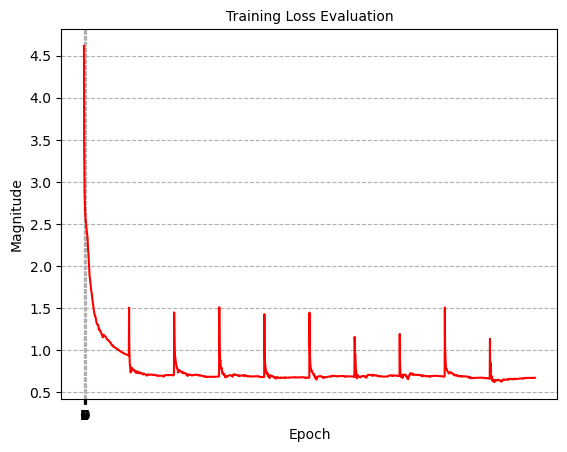

In [13]:
# Plot losses
fig, ax = plt.subplots()
plt.plot(losses, color='red')
plt.title('Training Loss Evaluation', fontsize=10)
ax.set_xticks([x for x in range(epochs)])
ax.set_xticklabels([x for x in range(epochs)])

ax.grid(True, linestyle='--')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Magnitude', fontsize=10)
plt.show()

### Test Model on Test Dataset

GroundTruth:   0  0


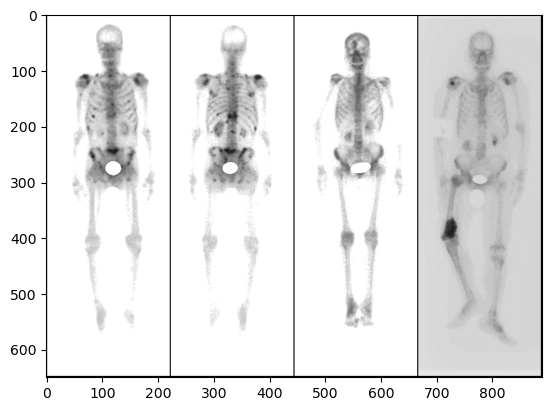

In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
plt.imshow(torchvision.utils.make_grid(images).squeeze().permute(1,2,0))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:2}' for j in range(2)))

In [15]:
outputs = net(images)
outputs

tensor([[ 6.7144,  7.2331, -1.9200, -1.9091, -1.9263, -1.7124, -1.7673, -1.8040,
         -1.7320, -1.7331],
        [ 6.7183,  7.2372, -1.9205, -1.9091, -1.9278, -1.7133, -1.7683, -1.8039,
         -1.7336, -1.7326],
        [ 6.8289,  7.3526, -1.9529, -1.9403, -1.9569, -1.7414, -1.7911, -1.8365,
         -1.7622, -1.7587],
        [ 5.7653,  6.2437, -1.6461, -1.6325, -1.6552, -1.4710, -1.5398, -1.5542,
         -1.4787, -1.5031]], grad_fn=<AddmmBackward0>)

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{predicted[labels[j]]:2}' for j in range(2)))

Predicted:   1  1


In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        print(f"Ground truth: {labels}, Predicted: {predicted}")
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: tensor([1, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 0]), Predicted: t

In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5} is {accuracy:.1f} %')

Accuracy for class:     0 is 0.0 %
Accuracy for class:     1 is 100.0 %
